# FedEx Exception Classification - TensorFlow Model

This notebook performs EDA and builds a TensorFlow classifier to predict exception types from delivery data.

## Model Architecture

- **Text Embedding**: For `driver_note` feature
- **Numerical Features**: For `gps_deviation_km`, `attempts`, `hub_delay_minutes`
- **Categorical Features**: For `weather_condition`, `package_scan_result`, `time_of_day`
- **Dense Neural Network**: Simple but effective architecture
- **Output Classes**: 10 exception types

In [116]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalAveragePooling1D, Concatenate, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)


TensorFlow version: 2.20.0
NumPy version: 2.3.5
Pandas version: 2.3.3


## Step 1: Load and Explore Data


In [117]:
# Load the data
df = pd.read_excel('fedex_realistic_synthetic_50000.xlsx')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()


Dataset Shape: (50000, 8)

First few rows:


,driver_note,gps_deviation_km,weather_condition,attempts,hub_delay_minutes,package_scan_result,time_of_day,exception_label
0,system outage prevented update construction ma...,13.61,Rain,2,106,DAMAGED,Evening,System Error
1,icy roads unsafe for delivery 😕,18.56,Snow,1,156,DAMAGED,Morning,Weather Delay
2,Delay occurred because package torn needs repa...,8.16,Rain,2,101,OK,Afternoon,Package Damage
3,tracking data corrupted - caused exception,5.62,Clear,3,49,OK,Afternoon,System Error
4,Driver reported barcode unreadable could not s...,8.05,Rain,2,47,DAMAGED,Morning,Package Damage


In [118]:
# Basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("\nDataset Description:")
df.describe()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   driver_note          50000 non-null  object 
 1   gps_deviation_km     50000 non-null  float64
 2   weather_condition    50000 non-null  object 
 3   attempts             50000 non-null  int64  
 4   hub_delay_minutes    50000 non-null  int64  
 5   package_scan_result  50000 non-null  object 
 6   time_of_day          50000 non-null  object 
 7   exception_label      50000 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.1+ MB
None


Dataset Description:


,gps_deviation_km,attempts,hub_delay_minutes
count,50000.000000,50000.000000,50000.000000
mean,9.767744,2.047700,91.724800
std,5.416108,0.803292,48.026786
min,0.000000,1.000000,0.000000
25%,5.250000,1.000000,54.000000
50%,9.860000,2.000000,91.000000
75%,14.450000,3.000000,129.000000
max,19.000000,3.000000,180.000000


In [119]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*50)
print("\nUnique values in each column:")
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"\n{col}: {df[col].nunique()} unique values")
        if df[col].nunique() <= 10:
            print(f"  Values: {df[col].unique()}")


Missing Values:
driver_note            0
gps_deviation_km       0
weather_condition      0
attempts               0
hub_delay_minutes      0
package_scan_result    0
time_of_day            0
exception_label        0
dtype: int64


Unique values in each column:

driver_note: 9685 unique values

weather_condition: 4 unique values
  Values: ['Rain' 'Snow' 'Clear' 'Storm']

package_scan_result: 3 unique values
  Values: ['DAMAGED' 'OK' 'UNREADABLE']

time_of_day: 3 unique values
  Values: ['Evening' 'Morning' 'Afternoon']

exception_label: 10 unique values
  Values: ['System Error' 'Weather Delay' 'Package Damage' 'Unknown' 'Misroute'
 'Access Issue' 'Address Invalid' 'Customer Not Home' 'Hub Delay'
 'Driver Issue']


## Step 2: Exploratory Data Analysis (EDA)


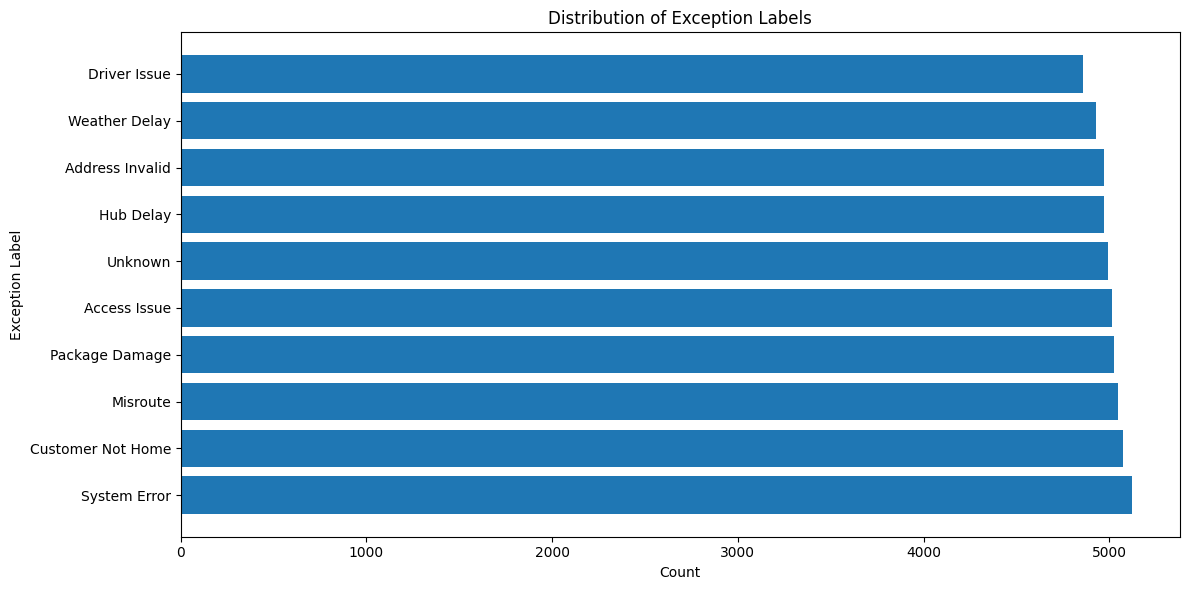

Exception Label Distribution:
exception_label
System Error         5124
Customer Not Home    5074
Misroute             5045
Package Damage       5026
Access Issue         5012
Unknown              4993
Hub Delay            4971
Address Invalid      4971
Weather Delay        4926
Driver Issue         4858
Name: count, dtype: int64


In [120]:
# Distribution of target variable
plt.figure(figsize=(12, 6))
exception_counts = df['exception_label'].value_counts()
plt.barh(exception_counts.index, exception_counts.values)
plt.xlabel('Count')
plt.ylabel('Exception Label')
plt.title('Distribution of Exception Labels')
plt.tight_layout()
plt.show()

print("Exception Label Distribution:")
print(exception_counts)


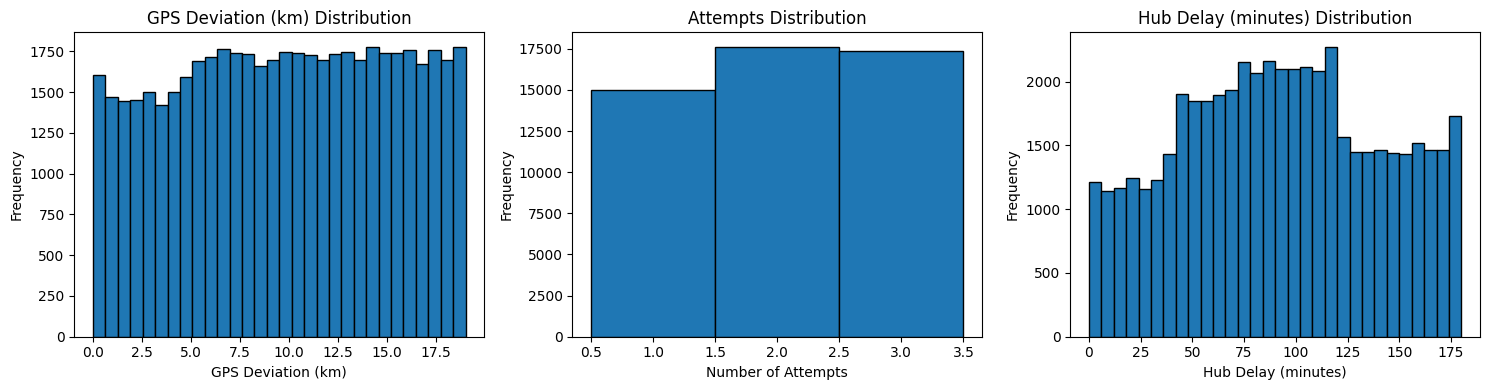

In [121]:
# Numerical features distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df['gps_deviation_km'], bins=30, edgecolor='black')
axes[0].set_title('GPS Deviation (km) Distribution')
axes[0].set_xlabel('GPS Deviation (km)')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['attempts'], bins=range(1, 5), edgecolor='black', align='left')
axes[1].set_title('Attempts Distribution')
axes[1].set_xlabel('Number of Attempts')
axes[1].set_ylabel('Frequency')

axes[2].hist(df['hub_delay_minutes'], bins=30, edgecolor='black')
axes[2].set_title('Hub Delay (minutes) Distribution')
axes[2].set_xlabel('Hub Delay (minutes)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


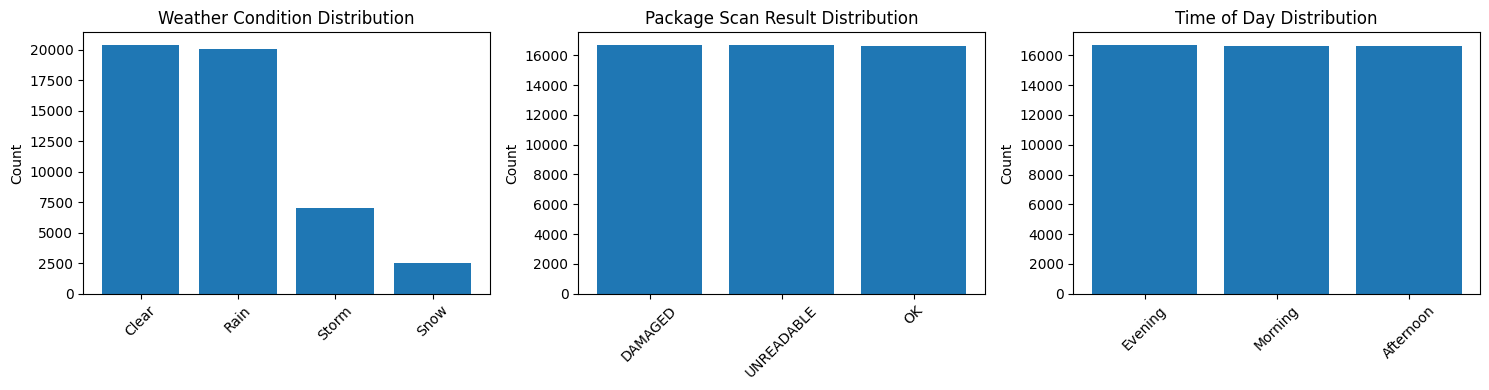

In [122]:
# Categorical features distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

weather_counts = df['weather_condition'].value_counts()
axes[0].bar(weather_counts.index, weather_counts.values)
axes[0].set_title('Weather Condition Distribution')
axes[0].set_ylabel('Count')
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45)

scan_counts = df['package_scan_result'].value_counts()
axes[1].bar(scan_counts.index, scan_counts.values)
axes[1].set_title('Package Scan Result Distribution')
axes[1].set_ylabel('Count')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)

time_counts = df['time_of_day'].value_counts()
axes[2].bar(time_counts.index, time_counts.values)
axes[2].set_title('Time of Day Distribution')
axes[2].set_ylabel('Count')
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()


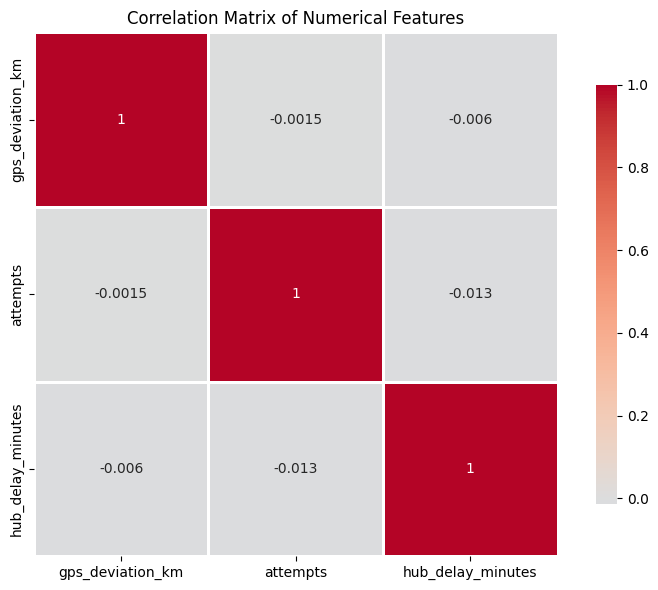

In [123]:
# Correlation matrix for numerical features
numerical_features = ['gps_deviation_km', 'attempts', 'hub_delay_minutes']
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()


In [124]:
# Sample driver notes
print("Sample Driver Notes:")
print("="*60)
for i in range(5):
    print(f"\n{i+1}. {df['driver_note'].iloc[i]}")
    print(f"   Exception: {df['exception_label'].iloc[i]}")


Sample Driver Notes:

1. system outage prevented update construction maybe? unsure
   Exception: System Error

2. icy roads unsafe for delivery 😕
   Exception: Weather Delay

3. Delay occurred because package torn needs repacking noted
   Exception: Package Damage

4. tracking data corrupted - caused exception
   Exception: System Error

5. Driver reported barcode unreadable could not scan noted
   Exception: Package Damage


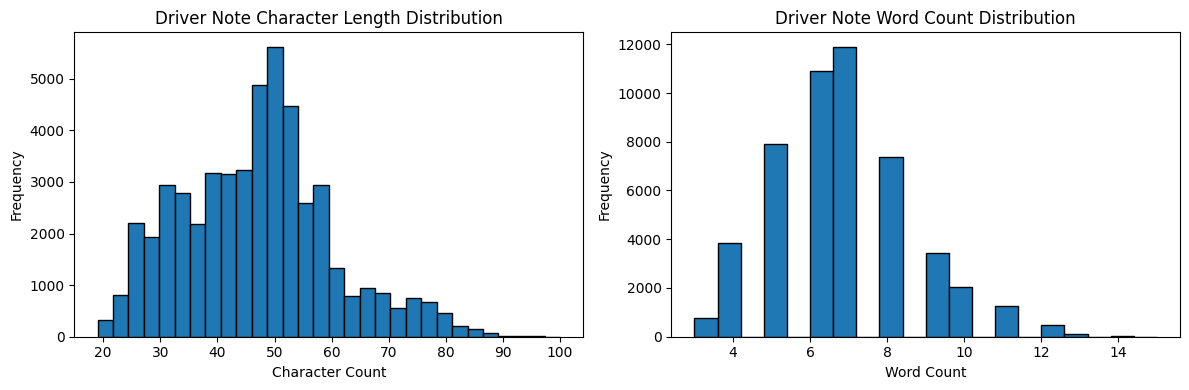


Driver Note Statistics:
Mean character length: 46.73
Mean word count: 6.74
Max character length: 100
Max word count: 15


In [125]:
# Analyze driver note lengths
df['driver_note_length'] = df['driver_note'].str.len()
df['driver_note_word_count'] = df['driver_note'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df['driver_note_length'], bins=30, edgecolor='black')
axes[0].set_title('Driver Note Character Length Distribution')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['driver_note_word_count'], bins=20, edgecolor='black')
axes[1].set_title('Driver Note Word Count Distribution')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\nDriver Note Statistics:")
print(f"Mean character length: {df['driver_note_length'].mean():.2f}")
print(f"Mean word count: {df['driver_note_word_count'].mean():.2f}")
print(f"Max character length: {df['driver_note_length'].max()}")
print(f"Max word count: {df['driver_note_word_count'].max()}")


## Step 3: Data Preprocessing


In [126]:
# Prepare features and target
X_text = df['driver_note'].values
X_numerical = df[['gps_deviation_km', 'attempts', 'hub_delay_minutes']].values
X_categorical = df[['weather_condition', 'package_scan_result', 'time_of_day']].copy()
y = df['exception_label'].values

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Target classes:", label_encoder.classes_)
print(f"\nEncoded target shape: {y_encoded.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")


Target classes: ['Access Issue' 'Address Invalid' 'Customer Not Home' 'Driver Issue'
 'Hub Delay' 'Misroute' 'Package Damage' 'System Error' 'Unknown'
 'Weather Delay']

Encoded target shape: (50000,)
Number of classes: 10


In [127]:
# Encode categorical features
categorical_encoders = {}
X_categorical_encoded = np.zeros((len(X_categorical), len(X_categorical.columns)))

for idx, col in enumerate(X_categorical.columns):
    le = LabelEncoder()
    X_categorical_encoded[:, idx] = le.fit_transform(X_categorical[col])
    categorical_encoders[col] = le
    print(f"{col}: {le.classes_}")

print(f"\nCategorical features shape: {X_categorical_encoded.shape}")


weather_condition: ['Clear' 'Rain' 'Snow' 'Storm']
package_scan_result: ['DAMAGED' 'OK' 'UNREADABLE']
time_of_day: ['Afternoon' 'Evening' 'Morning']

Categorical features shape: (50000, 3)


In [128]:
# Prepare text data for embedding
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text)

# Convert text to sequences
X_text_sequences = tokenizer.texts_to_sequences(X_text)
max_length = max(len(seq) for seq in X_text_sequences)
X_text_padded = pad_sequences(X_text_sequences, maxlen=max_length, padding='post')

print(f"Vocabulary size: {len(tokenizer.word_index) + 1}")
print(f"Max sequence length: {max_length}")
print(f"Padded text sequences shape: {X_text_padded.shape}")
print(f"\nSample sequence (first 10 tokens): {X_text_padded[0][:10]}")


Vocabulary size: 189
Max sequence length: 15
Padded text sequences shape: (50000, 15)

Sample sequence (first 10 tokens): [ 16  42  25 111  30  58  34   0   0   0]


In [129]:
# Scale numerical features
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

print("Numerical features shape:", X_numerical_scaled.shape)
print(f"\nScaled numerical features statistics:")
print(f"Mean: {X_numerical_scaled.mean(axis=0)}")
print(f"Std: {X_numerical_scaled.std(axis=0)}")


Numerical features shape: (50000, 3)

Scaled numerical features statistics:
Mean: [ 3.63797881e-17  2.35900188e-16 -4.06430445e-17]
Std: [1. 1. 1.]


In [130]:
# Combine all numerical features (numerical + categorical encoded)
X_all_numerical = np.hstack([X_numerical_scaled, X_categorical_encoded])
print(f"Combined numerical features shape: {X_all_numerical.shape}")
print(f"Features: 3 numerical + 3 categorical = 6 total numerical features")


Combined numerical features shape: (50000, 6)
Features: 3 numerical + 3 categorical = 6 total numerical features


In [131]:
# Split the data into train and test sets
X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_text_padded, X_all_numerical, y_encoded, 
    test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set size: {len(X_text_train)}")
print(f"Test set size: {len(X_text_test)}")
print(f"\nTraining set class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {u} ({label_encoder.inverse_transform([u])[0]}): {c}")


Training set size: 40000
Test set size: 10000

Training set class distribution:
  Class 0 (Access Issue): 4010
  Class 1 (Address Invalid): 3977
  Class 2 (Customer Not Home): 4059
  Class 3 (Driver Issue): 3886
  Class 4 (Hub Delay): 3977
  Class 5 (Misroute): 4036
  Class 6 (Package Damage): 4021
  Class 7 (System Error): 4099
  Class 8 (Unknown): 3994
  Class 9 (Weather Delay): 3941


## Step 4: Build TensorFlow Model


In [132]:
# Model hyperparameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 64
max_seq_length = max_length
num_numerical_features = X_all_numerical.shape[1]
num_classes = len(label_encoder.classes_)

print("Model Configuration:")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Embedding dimension: {embedding_dim}")
print(f"  Max sequence length: {max_seq_length}")
print(f"  Numerical features: {num_numerical_features}")
print(f"  Number of classes: {num_classes}")


Model Configuration:
  Vocabulary size: 189
  Embedding dimension: 64
  Max sequence length: 15
  Numerical features: 6
  Number of classes: 10


In [133]:
# Build the model architecture
# Input for text (driver_note)
text_input = Input(shape=(max_seq_length,), name='text_input')
text_embedding = Embedding(vocab_size, embedding_dim, input_length=max_seq_length)(text_input)
text_pooled = GlobalAveragePooling1D()(text_embedding)
text_dense = Dense(32, activation='relu')(text_pooled)
text_dropout = Dropout(0.3)(text_dense)

# Input for numerical features
numerical_input = Input(shape=(num_numerical_features,), name='numerical_input')
numerical_dense1 = Dense(32, activation='relu')(numerical_input)
numerical_dropout1 = Dropout(0.3)(numerical_dense1)
numerical_dense2 = Dense(16, activation='relu')(numerical_dropout1)

# Concatenate text and numerical features
concatenated = Concatenate()([text_dense, numerical_dense2])
combined_dense1 = Dense(64, activation='relu')(concatenated)
combined_dropout = Dropout(0.4)(combined_dense1)
combined_dense2 = Dense(32, activation='relu')(combined_dropout)

# Output layer
output = Dense(num_classes, activation='softmax', name='output')(combined_dense2)

# Create the model
model = Model(inputs=[text_input, numerical_input], outputs=output)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 15, 64)    │     12,096 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 32)        │        224 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ embedding_4[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 32)        │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 16)        │        528 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 48)        │          0 │ dense_20[0][0],   │
│ (Concatenate)       │                   │            │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 64)        │      3,136 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_23[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 32)        │      2,080 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 10)        │        330 │ dense_24[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,474 (79.98 KB)

 Trainable params: 20,474 (79.98 KB)

 Non-trainable params: 0 (0.00 B)

In [134]:
# Visualize model architecture
from tensorflow.keras.utils import plot_model
try:
    plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
    print("Model architecture saved to 'model_architecture.png'")
except:
    print("Could not generate model visualization (graphviz may not be installed)")


You must install pydot (`pip install pydot`) for `plot_model` to work.
Model architecture saved to 'model_architecture.png'


## Step 5: Train the Model


In [135]:
# Train the model
history = model.fit(
    [X_text_train, X_num_train],
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7126 - loss: 1.1209 - val_accuracy: 0.8926 - val_loss: 0.6047
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8892 - loss: 0.6614 - val_accuracy: 0.8929 - val_loss: 0.5682
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8895 - loss: 0.6234 - val_accuracy: 0.8931 - val_loss: 0.5551
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8901 - loss: 0.6013 - val_accuracy: 0.8931 - val_loss: 0.5476
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8904 - loss: 0.5888 - val_accuracy: 0.8934 - val_loss: 0.5427
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8908 - loss: 0.5746 - val_accuracy: 0.8940 - val_loss: 0.5373
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8908 - loss: 0.5703 - val_accuracy: 0.8940 - val_loss: 0.5346
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8918 - loss: 0.5614 - 

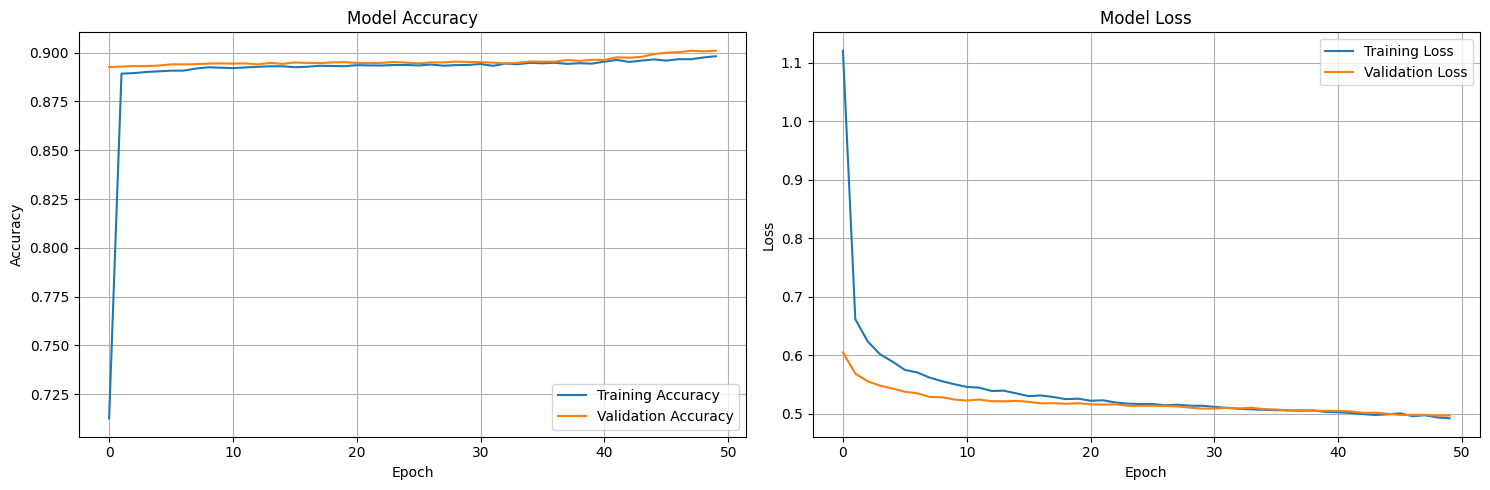

In [136]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


## Step 6: Evaluate the Model


In [137]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate([X_text_test, X_num_test], y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.4644
Test Accuracy: 0.9069


In [138]:
# Make predictions
y_pred_proba = model.predict([X_text_test, X_num_test])
y_pred = np.argmax(y_pred_proba, axis=1)

# Convert back to original labels
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [139]:
# Classification report
print("Classification Report:")
print("="*60)
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))


Classification Report:
                   precision    recall  f1-score   support

     Access Issue       0.88      0.91      0.90      1002
  Address Invalid       0.90      0.89      0.90       994
Customer Not Home       0.89      0.89      0.89      1015
     Driver Issue       0.90      0.91      0.91       972
        Hub Delay       0.92      0.91      0.91       994
         Misroute       0.90      0.89      0.90      1009
   Package Damage       0.89      0.90      0.90      1005
     System Error       0.90      0.90      0.90      1025
          Unknown       0.88      0.91      0.90       999
    Weather Delay       0.98      0.95      0.97       985

         accuracy                           0.91     10000
        macro avg       0.91      0.91      0.91     10000
     weighted avg       0.91      0.91      0.91     10000



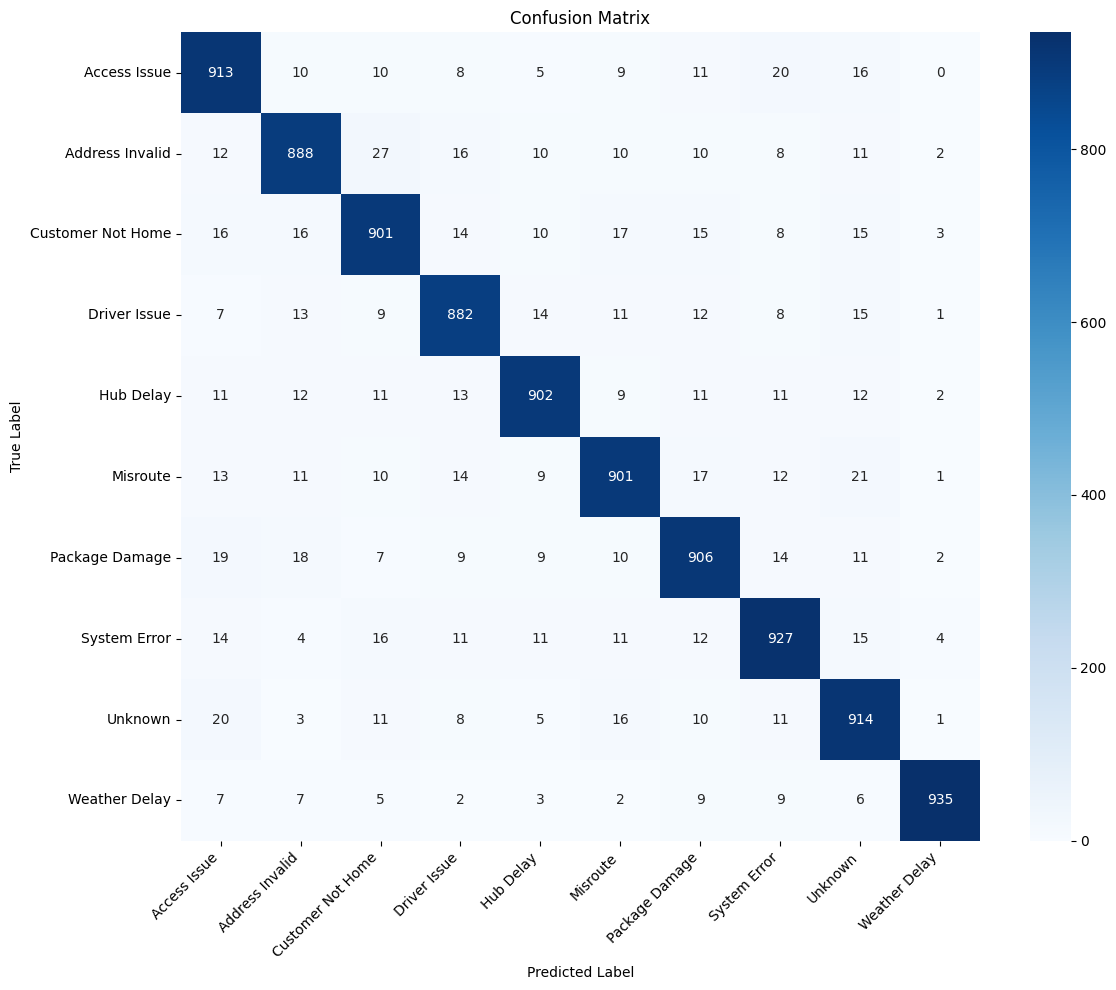

In [140]:
# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Per-Class Accuracy:
            Class  Accuracy
    Weather Delay  0.949239
          Unknown  0.914915
     Access Issue  0.911178
        Hub Delay  0.907445
     Driver Issue  0.907407
     System Error  0.904390
   Package Damage  0.901493
  Address Invalid  0.893360
         Misroute  0.892963
Customer Not Home  0.887685


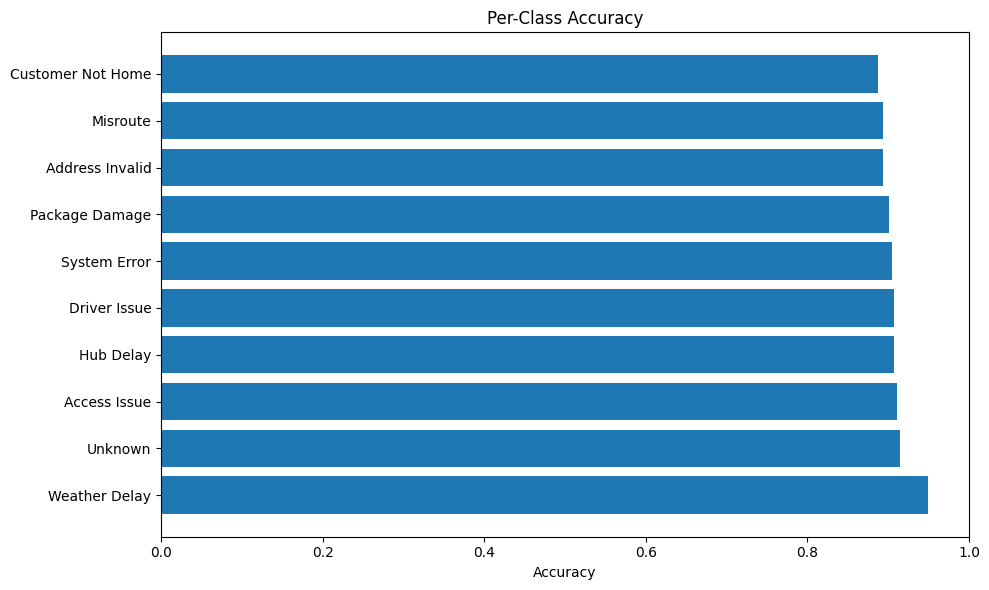

In [141]:
# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
class_acc_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Accuracy': class_accuracy
}).sort_values('Accuracy', ascending=False)

print("Per-Class Accuracy:")
print("="*60)
print(class_acc_df.to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(class_acc_df['Class'], class_acc_df['Accuracy'])
plt.xlabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.xlim([0, 1])
plt.tight_layout()
plt.show()


## Step 7: Sample Predictions


In [142]:
# Show some sample predictions
print("Sample Predictions on Test Set:")
print("="*80)

# Get indices of test set from original dataframe
test_indices = np.arange(len(df))[df.index.isin(range(len(df)))]
test_indices = test_indices[-len(y_test):]  # Approximate test indices

for i in range(min(10, len(X_text_test))):
    # Get original text
    original_text_idx = len(X_text_train) + i
    if original_text_idx < len(df):
        original_note = df.iloc[original_text_idx]['driver_note']
        true_label = y_test_labels[i]
        pred_label = y_pred_labels[i]
        confidence = y_pred_proba[i][y_pred[i]]
        
        print(f"\nSample {i+1}:")
        print(f"  Driver Note: {original_note}")
        print(f"  True Label: {true_label}")
        print(f"  Predicted Label: {pred_label}")
        print(f"  Confidence: {confidence:.4f}")
        print(f"  {'✓ Correct' if true_label == pred_label else '✗ Incorrect'}")


Sample Predictions on Test Set:

Sample 1:
  Driver Note: customer  not  home  for  scheduled  time  -  caused  exception
  True Label: Package Damage
  Predicted Label: Package Damage
  Confidence: 0.9087
  ✓ Correct

Sample 2:
  Driver Note: street name incorrect system record - caused exception 🤷
  True Label: System Error
  Predicted Label: System Error
  Confidence: 0.9095
  ✓ Correct

Sample 3:
  Driver Note: Tried delivering but sorting machine backlog at hub...
  True Label: Access Issue
  Predicted Label: Access Issue
  Confidence: 0.9045
  ✓ Correct

Sample 4:
  Driver Note: sorting machine backlog at hub scanner rebooted randomly
  True Label: System Error
  Predicted Label: System Error
  Confidence: 0.9065
  ✓ Correct

Sample 5:
  Driver Note: unexpected driver delay - caused exception retry tmrw
  True Label: Unknown
  Predicted Label: Unknown
  Confidence: 0.9179
  ✓ Correct

Sample 6:
  Driver Note: sidewalk completely blocked - caused exception
  True Label: Customer N

## Step 8: Save the Model


In [143]:
# Save the model
model.save('fedex_exception_classifier_model.h5')
print("Model saved as 'fedex_exception_classifier_model.h5'")

# Save preprocessing objects
import pickle

preprocessing_objects = {
    'tokenizer': tokenizer,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'categorical_encoders': categorical_encoders,
    'max_length': max_length
}

with open('preprocessing_objects.pkl', 'wb') as f:
    pickle.dump(preprocessing_objects, f)
    
print("Preprocessing objects saved as 'preprocessing_objects.pkl'")


Model saved as 'fedex_exception_classifier_model.h5'
Preprocessing objects saved as 'preprocessing_objects.pkl'


## Summary

This notebook has:

1. ✅ Performed comprehensive EDA on the FedEx exception data
2. ✅ Preprocessed text data using tokenization and embedding
3. ✅ Preprocessed numerical and categorical features
4. ✅ Built a TensorFlow dense neural network model with:
   - Text embedding for `driver_note`
   - Numerical features for the rest
   - 10 output classes for exception classification
5. ✅ Trained and evaluated the model
6. ✅ Saved the model and preprocessing objects for future use

The model is ready for deployment and can predict exception types based on delivery data.
